## Exloratory Data Analysis - Players Positions:

### Libraries
 In this cell, we are importing all the necessary libraries for our data analysis

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, hamming_loss
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping
import os
from tensorflow.keras.models import load_model
from datetime import datetime
from sklearn.decomposition import PCA

### Read and transform the data

In [18]:
#In this cell, we are reading the dataset and converting the 'date' column to 
# datetime format. We then extract only the date part from 'date' column

df_total = pd.read_csv('C:/Users/guill/OneDrive/Escritorio/Actual/Master IA/ProjAp/Models/players_pos_final.csv')
print(len(df_total))
df_total['date'] = pd.to_datetime(df_total['date'])

# Extract date only
df_total['date'] = df_total['date'].dt.date
df_total.sample(5)

176161


,Name,player_api_id,date,height,weight,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,...,GK,LB,LM,LW,LWB,RB,RM,RW,RWB,ST
83175,Y. Kaboul,26108,2014-09-18,190.50,192,79.0,79.0,1,2,1,...,0,0,0,0,0,0,0,0,0,0
63438,P. McCallum,244911,2013-10-11,190.50,165,60.0,67.0,1,1,1,...,0,0,0,0,0,0,0,0,0,1
103738,D. Robertson,25579,2011-08-30,177.80,143,64.0,70.0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
131629,K. Belhocine,149279,2010-08-30,187.96,183,65.0,67.0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
57474,M. Ishak,200601,2012-02-22,185.42,174,64.0,72.0,1,1,1,...,0,0,0,0,0,0,0,0,0,1


In [19]:
# Displaying the column names of the dataset
df_total.columns

Index(['Name', 'player_api_id', 'date', 'height', 'weight', 'overall_rating',
       'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes', 'CAM', 'CB', 'CDM', 'CF', 'CM', 'GK', 'LB', 'LM', 'LW',
       'LWB', 'RB', 'RM', 'RW', 'RWB', 'ST'],
      dtype='object')

### Graficos:

In this cell, we define a function that takes a player name as input and plots a PCA (Principal Component Analysis) scatter plot for the player and all other players who have played in the same positions as the input player

In [4]:
def PlayerPlotPCA(player_name):
  
    player_rows = df_total[df_total['Name'] == str(player_name)]
    player_rows_pos = player_rows.iloc[:, 43:57]
    positions = player_rows_pos.sum()
    possible_positions = positions[positions > 0]
    list_pos = list(possible_positions.index)

    other_players_pos = df_total[(df_total[list_pos] == 1).any(axis=1)]  # Nuevo dataframe con las filas filtradas
    
    samepos_players_stats = other_players_pos.iloc[:, 4:41]

    pca = PCA(n_components=2)
    samepos_players_stats_pca = pca.fit_transform(samepos_players_stats)

    # Define the figure and axis objects
    fig, ax = plt.subplots(figsize=(12, 8))
    # Set the title of the plot
    ax.set_title('PCA Results for ' + ' - '.join(list_pos) + ' Players and ' + str(player_name), fontsize=20)

    # Set the x and y axis labels
    ax.set_xlabel('PCA Component 1', fontsize=14)
    ax.set_ylabel('PCA Component 2', fontsize=14)

    # Set the font size of the tick labels
    ax.tick_params(axis='both', which='major', labelsize=12)

    # Add a grid to the plot
    ax.grid(True, linestyle='--', alpha=0.5)

    # Plot the PCA results for all LB players
    ax.scatter(samepos_players_stats_pca[:, 0], samepos_players_stats_pca[:, 1], label= ','.join(list_pos) + ' Players',alpha=0.1, color='blue')

    # Plot the point for J. Alba in a different color
    player_rows_pca = pca.transform(player_rows[samepos_players_stats.columns])
    ax.scatter(player_rows_pca[:, 0], player_rows_pca[:, 1], color='red', label=str(player_name), alpha=0.8)

    # Add a legend to the plot
    ax.legend(loc='upper right', fontsize=14)

    # Show the plot
    plt.show()


Using the defined function to plot PCA scatter plots for different players.

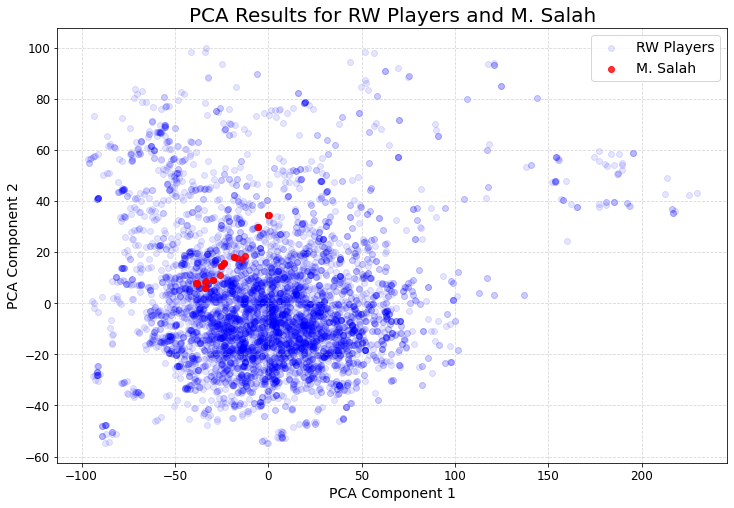

In [5]:
PlayerPlotPCA('M. Salah')

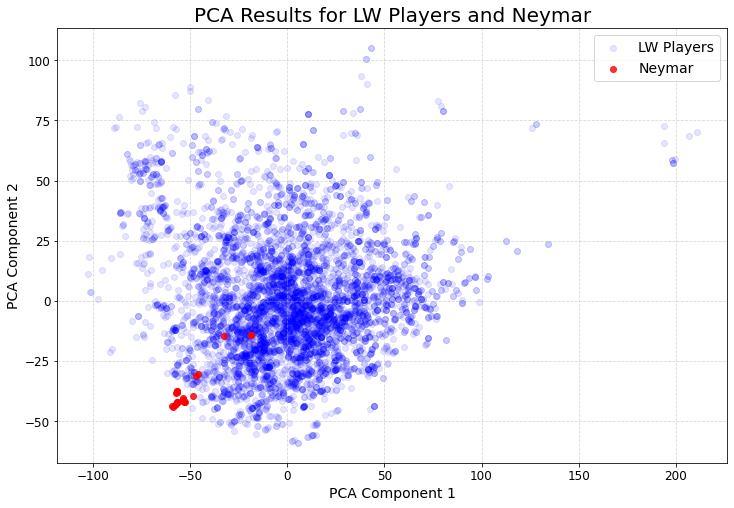

In [6]:
PlayerPlotPCA('Neymar')

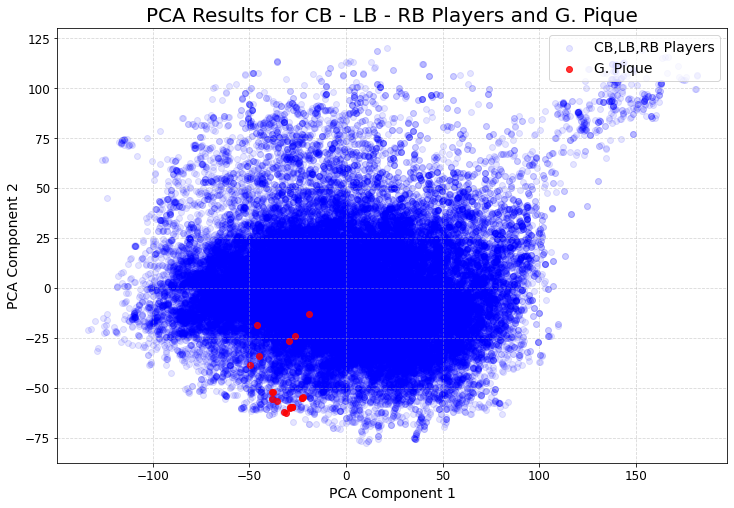

In [7]:
PlayerPlotPCA('G. Pique')

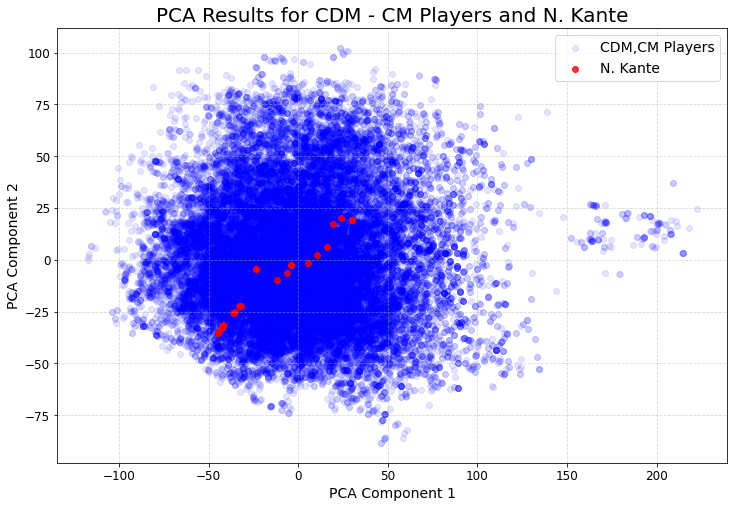

In [8]:
PlayerPlotPCA('N. Kante')

In this cell, we define a function to plot the trend of a specified rating metric (like 'overall_rating', 'finishing' etc.) over different seasons for a specified player

In [9]:
def PlayerRating(player_name, colname):
  
    player_rows = df_total[df_total['Name'] == str(player_name)]
    sesons = player_rows['date']


    # Create plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(sesons, player_rows[str(colname)], color='blue', linewidth=2)

    # Set x-axis labels to horizontal
    plt.xticks(rotation=90)

    # Add labels and title
    ax.invert_xaxis()
    ax.set_xlabel('Season')
    ax.set_ylabel('Overall Rating')
    ax.set_title(str(player_name) + ' Overall Rating')

    # Add grid
    ax.grid(True, linestyle='', alpha=0.5)
    plt.gca().invert_xaxis()

    # Show plot
    plt.show()


Using the defined function to plot the 'overall_rating' and 'finishing' metric trend for the player 'C. Ronaldo' 

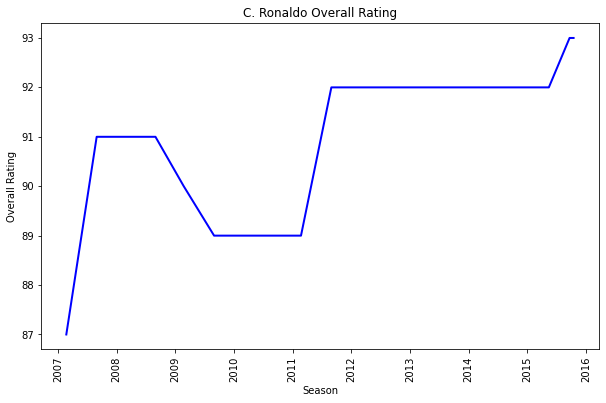

In [10]:
PlayerRating('C. Ronaldo', 'overall_rating')

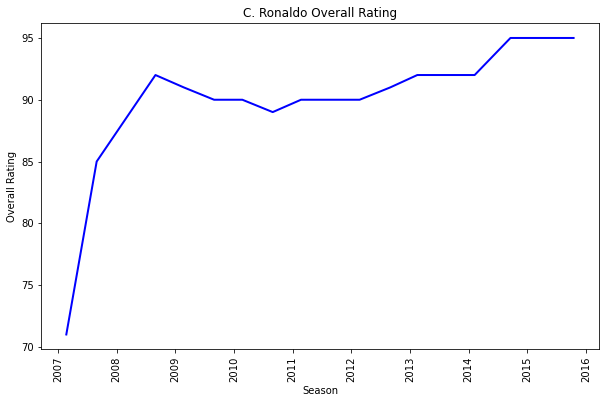

In [11]:
PlayerRating('C. Ronaldo', 'finishing')

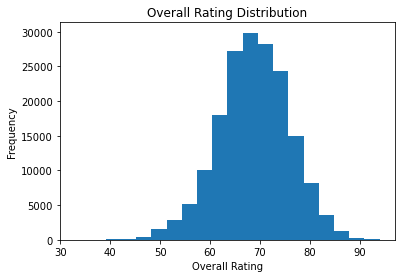

In [14]:
plt.hist(df_total['overall_rating'], bins=20)
plt.xlabel('Overall Rating')
plt.ylabel('Frequency')
plt.title('Overall Rating Distribution')
plt.show()


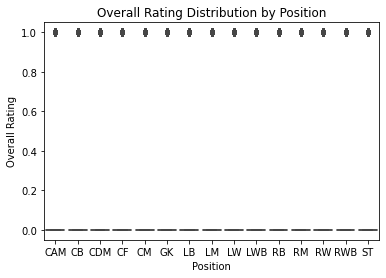

In [15]:
positions = ['CAM', 'CB', 'CDM', 'CF', 'CM', 'GK', 'LB', 'LM', 'LW', 'LWB', 'RB', 'RM', 'RW', 'RWB', 'ST']
df_positions = df_total[positions]
df_positions = df_positions.melt(var_name='Position', value_name='Overall Rating')

sns.boxplot(x='Position', y='Overall Rating', data=df_positions)
plt.xlabel('Position')
plt.ylabel('Overall Rating')
plt.title('Overall Rating Distribution by Position')
plt.show()

C